# Tutorial: Introductory Tutorial: Supervised Learning with PINA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial20/tutorial.ipynb)


> ##### ⚠️ ***Before starting:***
> We assume you are already familiar with the concepts covered in the [Getting started with PINA](https://mathlab.github.io/PINA/_tutorial.html#getting-started-with-pina) tutorials. If not, we strongly recommend reviewing them before exploring this advanced topic.

In this tutorial, we will demonstrate a typical use case of **PINA** for Neural Operator learning. We will cover the basics of training a Neural Operator with PINA, if you want to go further into the topic look at our dedicated [tutorials](https://mathlab.github.io/PINA/_tutorial.html#neural-operator-learning) on the topic.

Let's start by importing the useful modules:

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from pina import Trainer
from pina.solver import SupervisedSolver
from pina.model import KernelNeuralOperator
from pina.model.block import FourierBlock1D
from pina.problem.zoo import SupervisedProblem

## Learning Differential Operators via Neural Operator

In this tutorial, we explore how **Neural Operators** can be used to learn and approximate **differential operators**, which are fundamental in modeling physical and engineering systems governed by differential equations.

### What Are Neural Operators?

**Neural Operators (NOs)** are a class of machine learning models designed to learn mappings *between function spaces*, unlike traditional neural networks which learn mappings between finite-dimensional vectors. In the context of differential equations, this means a Neural Operator can learn the **solution operator**:
$$
\mathcal{G}(a) = u,
$$
where $a$ is an input function (e.g., a PDE coefficient) and $u$ is the solution function.

### Why Are Neural Operators Useful?

- **Mesh-free learning**: Neural Operators work directly with functions, allowing them to generalize across different spatial resolutions or grids.
- **Fast inference**: Once trained, they can predict the solution of a PDE for new input data almost instantaneously.
- **Physics-aware extensions**: Some variants can incorporate physical laws and constraints into the training process, improving accuracy and generalization.

## Learning the 1D Advection Equation with a Neural Operator

To make things concrete, we'll a Neural Operator to learn the 1D advection equation. We generate synthetic data based on the analytical solution:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$

For a given initial condition $u(x, 0)$, the exact solution at time $t$ is:

$$
u(x, t) = u(x - ct)
$$

We use this property to generate training data without solving the PDE numerically.

### Problem Setup

1. **Define the spatial domain**:  We work on a 1D grid $x \in [0, 1]$ with periodic boundary conditions.

2. **Generate initial conditions**:  Each initial condition $u(x, 0)$ is created as a sum of sine waves with random amplitudes and phases:
   $$
   u(x, 0) = \sum_{k=1}^K A_k \sin(2\pi k x + \phi_k)
   $$
   where $A_k \in [0, 0.5]$ and $\phi_k \in [0, 2\pi]$ are sampled randomly for each sample.

3. **Compute the solution at time $t$**:  
   Using the analytical solution, we shift each initial condition by $t=0.5$ ($c=1$), applying periodic wrap-around:
   $$
   u(x, t=0.5) = u(x - 0.5)
   $$

4. **Create input-output pairs**:  The input to the model is the function $u(x, 0)$, and the target output is $u(x, 0.5)$. These pairs can be used to train a Neural Operator to learn the underlying differential operator.

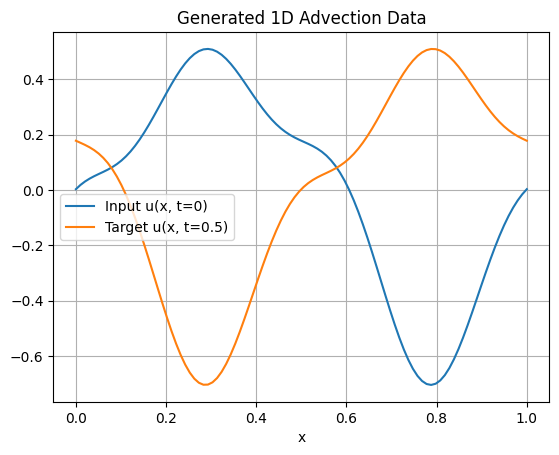

In [18]:
def generate_data(n_samples, x, c=1, t=0.5):
    x = x.T.repeat(n_samples, 1)
    u0 = torch.zeros_like(x)
    ut = torch.zeros_like(x)
    for k in range(1, 4):
        amplitude = torch.rand(n_samples, 1) * 0.5
        phase = torch.rand(n_samples, 1) * 2 * torch.pi
        u0 += amplitude * torch.sin(2 * torch.pi * k * x + phase)
        shifted_x = (x - c * t) % 1.0  # periodic shift
        ut += amplitude * torch.sin(2 * torch.pi * k * shifted_x + phase)
    return u0, ut


# define discretization train
x_train = torch.linspace(0, 1, 100).reshape(-1, 1)

# define input and target
input, target = generate_data(10000, x_train)

# visualize the data
plt.plot(x_train, input[0], label=f"Input u(x, t=0)")
plt.plot(x_train, target[0], label=f"Target u(x, t=0.5)")
plt.title("Generated 1D Advection Data")
plt.xlabel("x")
plt.legend()
plt.grid(True)

## Solving the Neural Operator Problem

At their core, **Neural Operators** transform an input function $a$ into an output function $u$. The general structure of a Neural Operator consists of three key components:

<p align="center">
    <img src="../static/neural_operator.png" alt="Neural Operators" width="800"/>
</p>


1. **Encoder**: The encoder maps the input into a specific embedding space.

2. **Processor**: The processor consists of multiple layers performing **function convolutions**, which is the core computational unit in a Neural Operator. 
3. **Decoder**:  The decoder maps the processor's output back into the desired output space.

By varying the design and implementation of these three components — encoder, processor, and decoder — different Neural Operators are created, each tailored for specific applications or types of data.

### Types of Neural Operators

Different variants of Neural Operators are designed to solve specific tasks. Some prominent examples include:

- **Fourier Neural Operator (FNO)**:  
   The **Fourier Neural Operator** utilizes the **Fourier transform** in the processor to perform global convolutions. This enables the operator to capture long-range dependencies efficiently. FNOs are particularly useful for problems with periodic data or problems where global patterns and interactions are important.  
   ➤ [Learn more about FNO](https://mathlab.github.io/PINA/_rst/model/fourier_neural_operator.html).

- **Graph Neural Operator (GNO)**:  
   The **Graph Neural Operator** leverages **Graph Neural Networks (GNNs)** to exchange information between nodes, enabling the operator to perform convolutions on unstructured domains, such as graphs or meshes. GNOs are especially useful for problems that naturally involve irregular data, such as graph-based datasets or data on non-Euclidean spaces.  
   ➤ [Learn more about GNO](https://mathlab.github.io/PINA/_rst/model/graph_neural_operator.html).

- **Deep Operator Network (DeepONet)**:  
   **DeepONet** is a variant of Neural Operators designed to solve operator equations by learning mappings between input and output functions. Unlike other Neural Operators, **DeepONet** does not use the typical encoder-processor-decoder structure. Instead, it uses two distinct neural networks:
   
   1. **Branch Network**: Takes the **function inputs** (e.g., $u(x)$) and learns a feature map of the input function.
   2. **Trunk Network**: Takes the **spatial locations** (e.g., $x$) and maps them to the output space.
   
   The output of **DeepONet** is the combination of these two networks' outputs, which together provide the mapping from the input function to the output function. 
   ➤ [Learn more about DeepONet](https://mathlab.github.io/PINA/_rst/model/deeponet.html).

In this tutorial we will focus on Neural Operator which follow the Encoder - Processor - Decoder structure, which we call *Kernel* Neural Operator. Implementing kernel neural Operators in PINA is very simple, you just need to use the `KernelNeuralOperator` API.

### KernelNeuralOperator API
The `KernelNeuralOperator` API requires three parameters:  

1. `lifting_operator`: a `torch.nn.Module` apping the input to its hidden dimension (Encoder).

2. `integral_kernels`: a `torch.nn.Module` representing the integral kernels mapping each hidden representation to the next one.

3. `projection_operator`: a `torch.nn.Module` representing the hidden representation to the output function.

To construct the kernel, you can use the Neural Operator Blocks available in PINA (see [here](https://mathlab.github.io/PINA/_rst/_code.html#blocks)) or implement you own one! Let's build a simple FNO using the `FourierBlock1D`. In particular we will:

1. Define the encoder, a simple linear layer mapping the input dimension to the hidden dimension
2. Define the decoder, two linear layers mapping the hidden dimension to 128 and back to the input dimension
3. Define the processor, a two layer Fourier block with a specific hidden dimension.
4. Combine the encoder-processor-decoder using the `KernelNeuralOperator` API to create the `model`.


In [23]:
# 1. Define the encoder (simple linear layer 1->64)
class Encoder(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.enc = torch.nn.Linear(1, hidden_dim)

    def forward(self, x):
        # [B, Nx] -> [B, Nx, 1]
        x = x.unsqueeze(-1)
        # [B, Nx, 1] -> [B, Nx, 64]
        x = self.enc(x)
        # [B, Nx, 1] -> [B, 64, Nx]
        return x.permute(0, 2, 1)


# 2. Define the decoder (two linear layer 64->128->1)
class Decoder(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.dec = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
        )

    def forward(self, x):
        # [B, 64, Nx] -> [B, Nx, 64]
        x = x.permute(0, 2, 1)
        # [B, Nx, 64] -> [B, Nx, 1]
        x = self.dec(x)
        # [B, Nx, 1] -> [B, Nx]
        return x.squeeze(-1)


# 3. Define the processor (two FNO blocks of size 64)
class Processor(torch.nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.proc = torch.nn.Sequential(
            FourierBlock1D(64, 64, 8, torch.nn.ReLU),
            FourierBlock1D(64, 64, 8, torch.nn.ReLU),
        )

    def forward(self, x):
        return self.proc(x)


# 4. Define the model with KernelNeuralOperator
model = KernelNeuralOperator(
    lifting_operator=Encoder(),
    integral_kernels=Processor(),
    projection_operator=Decoder(),
)

Done! Let's now solve the Neural Operator problem. The problem we will define is a basic `SupervisedProblem`, and we will use the `SupervisedSolver` to train the Neural Operator.

> **👉 We have a dedicated [tutorial](https://mathlab.github.io/PINA/tutorial16/tutorial.html) to teach how to build a Problem from scratch — have a look if you're interested!**

> **👉 We have a dedicated [tutorial](http://mathlab.github.io/PINA/_rst/tutorials/tutorial18/tutorial.html) for an overview of Solvers in PINA — have a look if you're interested!**

In [24]:
# making the problem
problem = SupervisedProblem(input, target)

# making the solver
solver = SupervisedSolver(problem, model, use_lt=False)

# simple training
trainer = Trainer(
    solver,
    max_epochs=3,
    train_size=0.8,
    test_size=0.2,
    batch_size=256,
    accelerator="cpu",
    enable_model_summary=False,
)
trainer.train()
_ = trainer.test()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_loss_epoch       0.0004166161816101521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Visualizing the Predictions

As we can see, we have achieved a very low MSE, even after training for only one epoch. Now, we will visualize the results in the same way as we did previously:

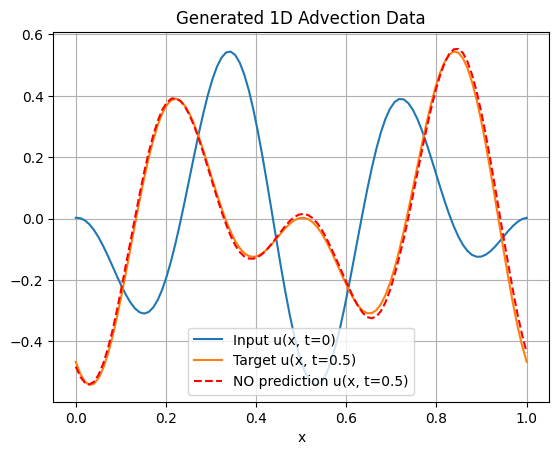

In [30]:
# generate new data
input, target = generate_data(100, x_train)

# compute the predicted solution
prediction = solver(input).detach()

# plot
plt.plot(x_train, input[0], label=f"Input u(x, t=0)")
plt.plot(x_train, target[0], label=f"Target u(x, t=0.5)")
plt.plot(x_train, prediction[0], "--r", label=f"NO prediction u(x, t=0.5)")
plt.title("Generated 1D Advection Data")
plt.xlabel("x")
plt.legend()
plt.grid(True)

Nice! We can see that the network is correctly learning the solution operator and it was very simple!

## What's Next?

Congratulations on completing the introductory tutorial on Neural Operators! Now that you have a solid foundation, here are a few directions you can explore:

1. **Experiment with Training Duration & Network Architecture** — Try different training durations and tweak the network architecture to optimize performance. Choose different integral kernels and see how the results vary.

2. **Explore Other Models in `pina.model`** — Check out other models available in `pina.model` or design your own custom PyTorch module to suit your needs. What about trying a `DeepONet`?

3. **...and many more!** — The possibilities are vast! Continue experimenting with advanced configurations, solvers, and features in PINA. For example, consider incorporating physics-informed terms during training to enhance model generalization.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).